# Handwritten Number Recognition with Multiple Digits
## 1, 2, 3-digit numbers

In [57]:
import matplotlib.pyplot as plt
import csv
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import cv2

from keras import Model
from keras import Input
from keras.layers import Dense
from keras.layers import Normalization
from keras.layers import Rescaling
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.callbacks import EarlyStopping

from keras.datasets import mnist

from keras.optimizers import RMSprop

from keras.utils import to_categorical

from keras.datasets.mnist import load_data

# Reading the images from the 'Dataset' folder

Sort by filename

In [58]:
folder_path = "Dataset/"

data = []

file_names = os.listdir(folder_path)

def extract_number(filename):
    return int(''.join(filter(str.isdigit, filename)))

sorted_file_names = sorted(file_names, key=extract_number)

Convert images to grayscale and into numpy arrays.

The images are added to the data list.

In [59]:
for filename in sorted_file_names:
    # Opening the image file using PIL
    image = Image.open(os.path.join(folder_path, filename))

    image_data = np.array(image)
    gray_image = cv2.cvtColor(image_data, cv2.COLOR_BGR2GRAY)

    data.append(255 - gray_image)

Read all the labels from a csv file and convert them into a numpy array.

In [60]:
labels_array = []

with open('labels.csv', 'r') as csvfile:
    csvreader = csv.reader(csvfile)
    for row in csvreader:
        for label in row:
            labels_array.append(label)
            
labels = np.array(labels_array)

# Explore the Data - Visualization

Check how an image looks like after reading it from the input, and its label.

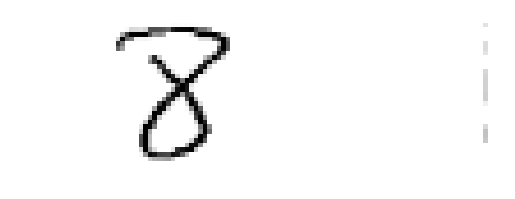

In [61]:
fig = plt.figure()
plt.imshow(data[1678], cmap=plt.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [62]:
labels[1678]

'8'

The labels and number are in correct pairs, as the above example shows.

## Reshaping

Because the sizes of the images differ, padding must be added so all images have the same dimensions.

In [63]:
#select max width for the padding
print(len(data[0][0]))
max_width = len(data[0][0])
#select max height for the padding
print(len(data[0]))
max_height = len(data[0])

75
26


In [64]:
for i in range(0,len(data)):
    #print(len(data[i][0]))
    if max_width < len(data[i][0]):
        max_width = len(data[i][0])
    #print(len(data[i]))
    if max_height < len(data[i]):
        max_height = len(data[i])
        
print(max_width)
print(max_height)

108
40


After finding the max width and length, we insert white pixels into the matrixes representing the images (rows or columns of 0s).

In [65]:
#padding
padded_images = []
for i in range(0,len(data)):
    image = data[i]
    padded_image = np.pad(image, ((0, max_height - image.shape[0]), (0, max_width - image.shape[1])), mode='constant')
    padded_images.append(padded_image)

# for i in range(len(data) - 1):
#     print("Height: ", len(padded_images[i]))
#     print("Width: ", len(padded_images[i][0]))

Check randomly how an image looks like after inserting padding.

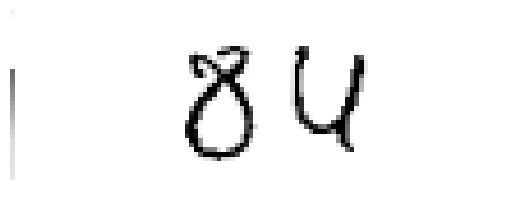

In [66]:
fig = plt.figure()
plt.imshow(data[1675], cmap=plt.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [67]:
# Convert the labels to have type int instead of string
labels = labels.astype(int)

# Split the data - Train and Test Sets

In [68]:
# Split the data and labels into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_images, labels, test_size=0.2)

# Print the size of the training and testing sets
print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))

Training set size: 8000
Testing set size: 2000


In [69]:
# Convert all of them into numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [70]:
# X_train = x_train.reshape((8000, max_height*max_width))
# X_test = x_test.reshape((2000, max_height*max_width))

Check an image from the training set and its label.

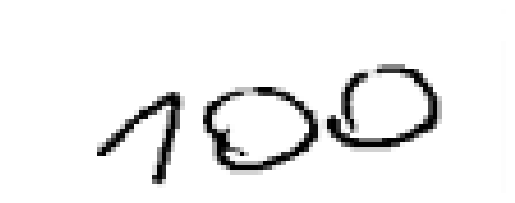

In [71]:
fig = plt.figure()
plt.imshow(X_train[0], cmap=plt.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [72]:
# Take a look at its class
y_train[0]

100

As the previous example shows, the labels and images are in order.

# Building a Convolutional Neural Net

Our model consists of several layers: 
* an input layer of size max width and max height, the depth being 1 for grayscale image
* a rescaling layer: to work easily with the numbers in the matrices, all numbers should be between 0 and 1. Therefore, the greyscale values should be divided by 255
* convolutional layers: they contain 64 or 128 filters/neurons; the chosen kernel size is 3x3 and the activation function is ReLU
* max pooling layers: they decrease the input to half of its size, however, the depth doesn't change; the pooling window indicates the decrease height/2, width/2
* flattening layer: creates a list from the matrices, multiplying all the dimensions
* dense layer: they are the tipical neural net layers where all neurons are connected with every other neuron; one of the dense layers has 2048, the other one 1000 neurons
* output layer: the last dense layer, which has 1000 neurons, one to predict each number from the interval [0-999]; it uses softmax activation function

In [73]:
inputs = Input(shape=(40, 108, 1))
x = Rescaling(scale=1./255)(inputs)
x = Conv2D(filters=64, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=128, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=128, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(2048, activation="relu")(x)
outputs = Dense(1000, activation="softmax")(x)
convnet = Model(inputs, outputs)
convnet.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [74]:
convnet.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 40, 108, 1)]      0         
                                                                 
 rescaling_2 (Rescaling)     (None, 40, 108, 1)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 38, 106, 64)       640       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 19, 53, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 51, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 8, 25, 128)       0         
 2D)                                                       

The summary shows the output shape, where we can see how the 40 * 108 size matrix decreases gradually, and it shows the number of parameters in each layer. The number of these parameters can be calculated by taking into consideration the type of the layer and the shape of the previous layer.

# Training the Neural Net

The .fit function trains the neural net, using a batch size of 128 (chosen by us), and it calculates in 10 epochs.

In [75]:
convnet.fit(X_train, y_train, epochs=10, batch_size=128, 
            validation_split=0.2)
            #callbacks=[EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)])

Epoch 1/10
50/50 [==============================] - 64s 1s/step - loss: 4.9822 - accuracy: 0.0759 - val_loss: 4.3813 - val_accuracy: 0.1094
Epoch 2/10
50/50 [==============================] - 60s 1s/step - loss: 4.0286 - accuracy: 0.1311 - val_loss: 3.6745 - val_accuracy: 0.2069
Epoch 3/10
50/50 [==============================] - 61s 1s/step - loss: 2.9800 - accuracy: 0.3162 - val_loss: 2.7045 - val_accuracy: 0.3800
Epoch 4/10
50/50 [==============================] - 61s 1s/step - loss: 1.7992 - accuracy: 0.5494 - val_loss: 2.2302 - val_accuracy: 0.5025
Epoch 5/10
50/50 [==============================] - 61s 1s/step - loss: 0.9253 - accuracy: 0.7383 - val_loss: 2.1344 - val_accuracy: 0.5412
Epoch 6/10
50/50 [==============================] - 61s 1s/step - loss: 0.3560 - accuracy: 0.8961 - val_loss: 2.5711 - val_accuracy: 0.5663
Epoch 7/10
50/50 [==============================] - 63s 1s/step - loss: 0.1488 - accuracy: 0.9544 - val_loss: 2.7140 - val_accuracy: 0.5788
Epoch 8/10
50/50 [==

# Test the Model

In [76]:
test_loss, test_acc = convnet.evaluate(X_test, y_test)
test_acc

63/63 [==============================] - 6s 96ms/step - loss: 2.8179 - accuracy: 0.6145


0.6144999861717224

We can clearly see that the test accuracy is way lower than the training accuracy of the model.

In the process of fine tuning and tring out different no of neurons, different kernels and different number of layers of different kind, we got vairous results.

At first we had a 0.3 accuracy after testing.

Then we changed the parameters and the convolutional layers to get a higher accuracy.

The next try resulted in 0.44 accuracy.

# Final Result

The highest accuracy that we could achieve with this model was 0.62 so far. This result can be improved with fiddling around with the layers and parameters. We have built this model from scratch and it took a lot of time to run it after modifications on our laptops. Therefore, we have decided to stop at this accuracy rate, however small it is compared to a desired 80-90%.